In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats

# Data loading
Я обрав компанію Goldman Sachs.

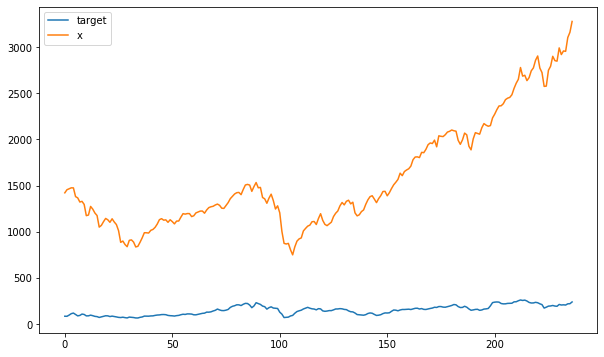

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_gs = pd.read_csv('GS.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_sp500 = pd.read_csv('^GSPC.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

target = ((data_gs['High'] + data_gs['Low']) / 2.).values
x = ((data_sp500['High'] + data_sp500['Low'])/2.).values

plt.figure(figsize=(10, 6))
plt.plot(target, label='target')
plt.plot(x, label='x')
plt.legend();

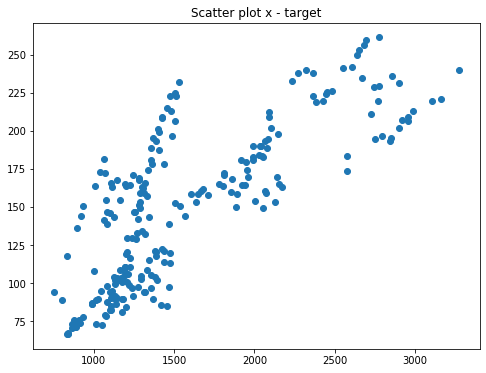

In [3]:
plt.figure(figsize=(8, 6))
plt.title('Scatter plot x - target')
plt.scatter(x, target);

### Model parameters

In [4]:
def model_parameters_1(x, y):
    n = x.shape[0]
    x_mean = x.mean()
    y_mean = target.mean()
    x_y_product = np.dot(x, target)
    beta = ((x_y_product / n) - x_mean * y_mean ) / (1 / n * np.sum(x ** 2) - x_mean **2 )
    alpha = y_mean - beta * x_mean
    
    print(f'=== Model1 coef ===')
    print(f'alpha: {alpha}    beta: {beta}')
    return alpha, beta

def model_parameters_2(x, y):
    x_mean = x.mean()
    y_mean = target.mean()
    beta = np.cov(x, target)[0][1] / np.var(x)
    alpha = y_mean - beta * x_mean
    
    print(f'=== Model2 coef ===')
    print(f'alpha: {alpha}    beta: {beta}')
    return alpha, beta

def model_parameters_3(x, y):
    from sklearn.linear_model import LinearRegression
    lin = LinearRegression()
    lin.fit(x.reshape(-1, 1), y)
    
    print(f'=== Model3 coef ===')
    print(f'alpha: {lin.intercept_}    beta: {lin.coef_[0]}')
    return lin.intercept_, lin.coef_[0]

def model_parameters_4(x, y):
    import statsmodels.api as sm
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    lin = model.fit()
    
    print(f'=== Model4 coef ===')
    print('alpha: {}    beta: {}'.format(lin.params[0], lin.params[1]))
    return lin.params[0], lin.params[1], lin


def predict(b_0, b_1, x):
    res = b_0 + b_1 * x
    return res

In [5]:
model_1 = model_parameters_1(x, target)
model_2 = model_parameters_2(x, target)
model_3 = model_parameters_3(x, target)
model_4 = model_parameters_4(x, target)

=== Model1 coef ===
alpha: 43.85423165520764    beta: 0.06712562610360161
=== Model2 coef ===
alpha: 43.40539240309401    beta: 0.0674100567226847
=== Model3 coef ===
alpha: 43.85423165520761    beta: 0.06712562610360162
=== Model4 coef ===
alpha: 43.85423165520749    beta: 0.06712562610360162


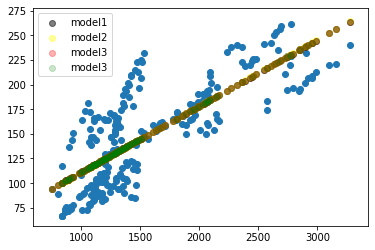

In [6]:
plt.scatter(x, target)
plt.scatter(x, predict(model_1[0], model_1[1], x), color='black', label='model1', alpha=0.5)
plt.scatter(x, predict(model_2[0], model_2[1], x), color='yellow', label='model2', alpha=0.4)
plt.scatter(x, predict(model_3[0], model_3[1], x), color='red', label='model3', alpha=0.3)
plt.scatter(x, predict(model_4[0], model_4[1], x), color='green', label='model3', alpha=0.2)
plt.legend();

# Model analysis

In [7]:
y_hat = predict(model_4[0], model_4[1], x)

In [8]:
model_4[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     369.6
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           3.97e-50
Time:                        18:15:40   Log-Likelihood:                -1157.0
No. Observations:                 237   AIC:                             2318.
Df Residuals:                     235   BIC:                             2325.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.8542      5.890      7.446      0.000      32.251      55.458
x1             0.0671      0.003     19.225      0.000       0.060       0.074
==============================================================================
Omnibus:                       18.239   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.562
Skew:                           0.608   Prob(JB):                     0.000154
Kurtosis:                       2.453   Cond. No.                     4.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Hypothesis testing  $\alpha$ = 0 
$H_0: \alpha = 0 $ <br>
$H_1: \alpha \ne 0 $ <br>
From the second table above in the __const__ row we can see that obtained t-test results are equal to 7.446 and corresponding p-value is 0.000. As obtained p-value is below 0.05 it means that the variable is significant . Therefore, the $\alpha$ is most probably different from 0. Lets check whether given confidence intervals in the table are true.

In [9]:
upper_bound = model_4[2].params[0] + stats.t.ppf(1-0.025, 250) * model_4[2].bse[0]
lower_bound = model_4[2].params[0] - stats.t.ppf(1-0.025, 250) * model_4[2].bse[0]
print('b_0 Upper_bound: ',upper_bound, ' Lower bound: ', lower_bound)

b_0 Upper_bound:  55.45428086695135  Lower bound:  32.254182443463634


### Hypothesis testing  $\beta$ = 0 
$H_0: \beta = 0 $ <br>
$H_1: \beta \ne 0 $ <br>
From the second table above in the __0__ row we can see that obtained t-test results are equal to 19.225 and corresponding p-value is 0.000. As obtained p-value is below 0.05 it means that the variable is significant . Therefore, the $\beta$ is most probably different from 0. Lets check whether given confidence intervals in the table are true.

In [10]:
upper_bound = model_4[2].params[1] + stats.t.ppf(1-0.025, 250) * model_4[2].bse[1]
lower_bound = model_4[2].params[1] - stats.t.ppf(1-0.025, 250) * model_4[2].bse[1]
print('b_1 Upper_bound: ',upper_bound, ' Lower bound: ', lower_bound)

b_1 Upper_bound:  0.07400225244685064  Lower bound:  0.06024899976035259


### r & $R^{2}$

In [11]:
# r and R_squared
print(f'table values R_squared: {model_4[2].rsquared}    r: {np.sqrt(model_4[2].rsquared)}') # program 
print(f'my values    R_squared: {np.var(y_hat) / np.var(target)}    r: {np.corrcoef(y_hat, target)[0][1]}') # my

table values R_squared: 0.6113160798913282    r: 0.7818670474520129
my values    R_squared: 0.6113160798913277    r: 0.781867047452013


### F-statistic
$H_0: \beta_1 ... \beta_n = 0 $  (if all $\beta$s are 0, then none of the independent variables matter. Therefore, our model has no merit)<br> 
$H_1$: at least one $\beta$ from $\beta_1 ... \beta_n \ne 0 $ <br>

In out case F-statistic is 369.6 with a p-value of close to 0.000. We can say that overall model is significant. One thing worth mentioning is, the lower the F-statistic, the closer model to be non-significant. 

### Predictions with 95% confidence intervals

In [12]:
yprd_ci_lower, yprd_ci_upper = summary_table(model_4[2], alpha = 0.05)[1][:, 4:6].T

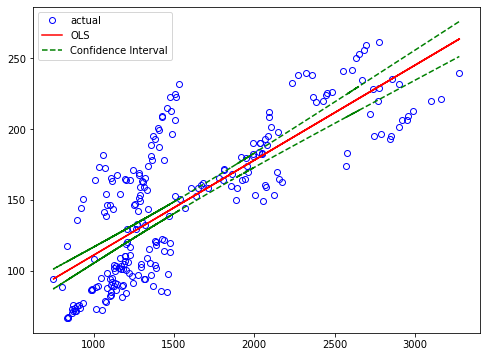

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(x, target, linestyle = "None", marker = "o", label = "actual", markerfacecolor = "None", color = "blue")
plt.plot(x, y_hat, color = "red", label = "OLS")
plt.plot(x, yprd_ci_lower, color = "green", linestyle = "--", label = "Confidence Interval")
plt.plot(x, yprd_ci_upper, color = "green", linestyle = "--")
plt.legend()
plt.show();

### Forecast

In [21]:
x_mat = x[-1] * 1.2
y_prd = predict(model_4[0], model_4[1], x_mat)
print(f'x = {x_mat} y_hat = {y_prd}')
print(f'y confidence intervals: ({y_prd}, {y_prd})')

x = 3931.4459477999994 y_hat = 307.75500239375
y confidence intervals: (307.75500239375, 307.75500239375)


In [23]:
x_mat = np.array([1, x[-1] * 1.2])
dt = model_4[2].get_prediction(x_mat).summary_frame(alpha = 0.05)
y_prd = dt['mean']
y_prd_ci_lower = dt['obs_ci_lower']
y_prd_ci_upper = dt['obs_ci_upper']

print(f'x = {x_mat} y_hat = {y_prd}')
print(f'y confidence intervals: ({y_prd_ci_lower}, {y_prd_ci_upper})')

In [24]:
dt

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,307.755002,8.476645,291.055078,324.454927,242.452723,373.057282
